# Modelo Presa-Depredador


$ P= P(t): $ número de depredadores en el instante t

$ N = N(t): $ número de presas en el instante t

$$
\begin{cases}
P'= -P + 2NP \\
N'= 5N -3NP  \\
P(0) = 2,  N(0) = 0.5\\
\end{cases}
$$

$$ t ∈ [0,10]$$

In [ ]:
# Importar librerias
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.autograd as grad
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
import math

## 1. Datos y representación gráfica

### 1.1 Runge Kutta 4


In [ ]:
def RungeKutta4SDO(f,y0,I,N):
  """
  Argumentos de entrada:
  - f: funcion
  - y0: dato inicial
  - I : intervalo [t0,tf]
  - N : numero de subintervalos

  Argumentos de salida:
  - t : puntos de particion
  - y : aproximaciones de la sol en dichos puntos
  """

  # Datos
  t0 = I[0]
  tf = I[1]
  N1 = N+1
  M = len(y0)

  h = (tf-t0)/N
  h2 = h*0.5
  h6 = h/6
  t = np.linspace(t0,tf,N1)
  t2 = t + h2

  # Inicializacion
  y = np.zeros((M,N1))
  y[:,0] = y0

  for k in range(N):
    K1 = f(y[:,k], t[k])
    K2 = f(y[:,k]+h2*K1, t2[k])
    K3 = f(y[:,k]+h2*K2, t2[k])
    K4 = f(y[:,k]+h*K3, t[k+1])
    y[:,k+1]= y[:,k] + h6*(K1+2*K2+2*K3+K4)


  return y,t

### 1.2 Modelo Presa - Depredador

In [ ]:
def presaDepredador(r,t):

  """
  r : es una matriz que contiene las variables dependientes
  t : vector de las variables independientes

  """

  y1 = r[0]
  y2 = r[1]

  dy1dt = -y1 + 2*y1*y2
  dy2dt = 5*y2 -3*y1*y2
  return np.array([dy1dt,dy2dt], float)

### 1.3 Resolución y representación gráfica

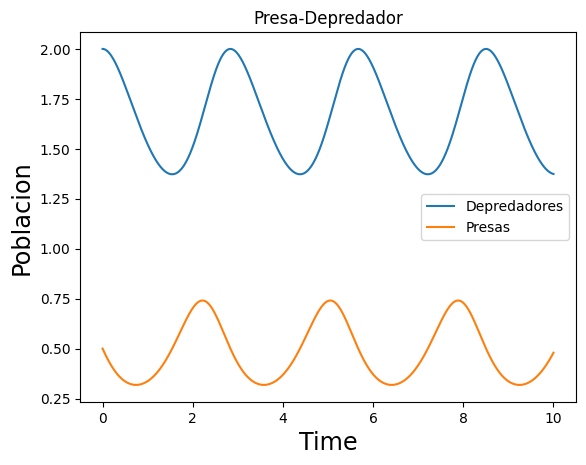

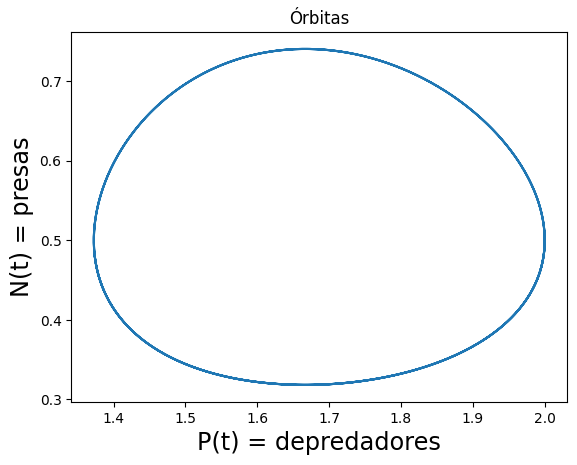

In [ ]:
N=3000
Nf = 1000 # puntos para evaluar el residuo
print_freq = 2000 # imprimir cada epoca

# We integrate between tMin and tMax .............
t0,tf = 0.0,10

y10,y20 = 2.0,0.5
y0 = np.array([y10,y20], float)


y,t = RungeKutta4SDO(presaDepredador,y0,[t0,tf],N) # lo resuelve por filas
y1 = y[0,:]
y2 = y[1,:]
# representacion de la solucion
fig1 = plt.figure(1)
plt.plot(t, y1, label = "Depredadores")
plt.plot(t, y2, label = "Presas")
plt.xlabel("t")
plt.ylabel("Poblacion")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("Poblacion",fontsize="xx-large")
plt.legend()
plt.title("Presa-Depredador")
plt.show()


# espacio de fases
fig2 = plt.figure(2)
plt.plot(y1, y2)
plt.xlabel("P(t) = depredadores",fontsize="xx-large")
plt.ylabel("N(t) = presas",fontsize="xx-large")
plt.title("Órbitas")
plt.show()


In [ ]:
y0 = [y10,y20]
sol = odeint(presaDepredador,y0,t) # lo resuelve por columnas
sol

array([[2.        , 0.5       ],
       [1.99998891, 0.49833613],
       [1.99995567, 0.49667792],
       ...,
       [1.37438311, 0.47650768],
       [1.37417426, 0.47790298],
       [1.37397825, 0.47930333]])

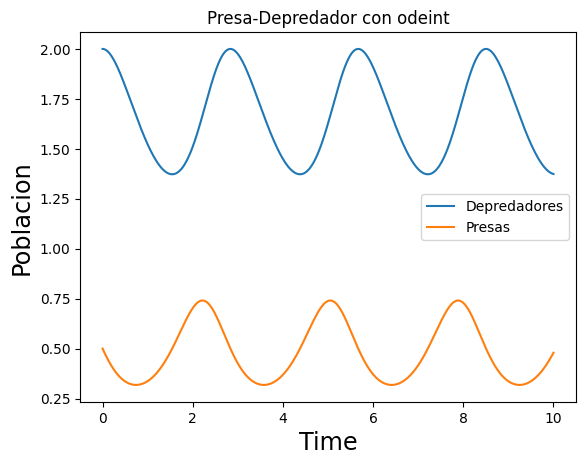

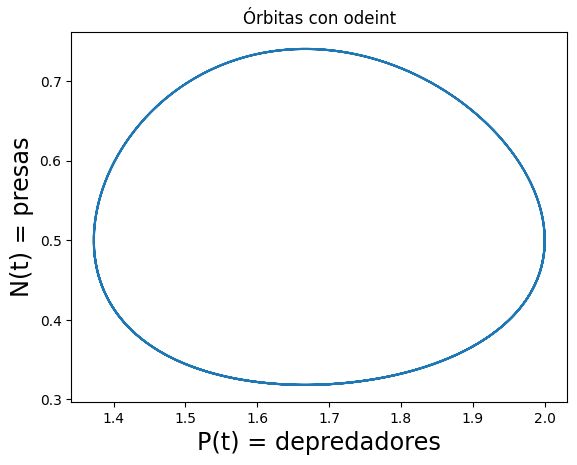

In [ ]:
# representacion de la solucion
fig3 = plt.figure(3)
plt.plot(t, sol[:,0], label = "Depredadores")
plt.plot(t, sol[:,1], label = "Presas")
plt.xlabel("t")
plt.ylabel("Poblacion")
plt.xlabel("Time",fontsize="xx-large")
plt.ylabel("Poblacion",fontsize="xx-large")
plt.legend()
plt.title("Presa-Depredador con odeint")
plt.show()


# espacio de fases
fig4 = plt.figure(4)
plt.plot(sol[:,0], sol[:,1])
plt.xlabel("P(t) = depredadores",fontsize="xx-large")
plt.ylabel("N(t) = presas",fontsize="xx-large")
plt.title("Órbitas con odeint")
plt.show()

## 2. Definición de la red neuronal

In [ ]:
# Fijamos la semilla
torch.manual_seed(1234)
np.random.seed(1234)


In [ ]:

class PINN(nn.Module):     # definir la clase (al heredar de nn.Module clase PINN
                           # tiene acceso a muchas utilidades y métodos proporcionados por PyTorch
                           # para el entrenamiento y la evaluación de modelos

    def __init__(self, input_size, hidden_size, output_size):    # Inicializador
                           # llamamos al inicializador de la clase base nn.Module mediante super()
                           # Esto asegura que todas las funcionalidades de nn.Module se inicialicen correctamente
        super(PINN, self).__init__()

        # Definir las capas de la red neuronal (aqui 3 capas lineales: nn.Linear)
        # Estas capas representan las conexiones ponderadas entre las neuronas de capas consecutivas.
        #  nn.Linear(input_size, hidden_size)
        #  input_size : es la cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: la cantidad de salidas (neuronas en la capa actual)
        # Una capa lineal significa que salida = Entradas×Pesos + Sesgo

        # Capa 1: Entrada con input_size características, salida con hidden_size características
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Capa 3: Entrada con hidden_size características, salida con 1 característica
        self.fc3 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos (I): Random Initialization
        # Inicializar los pesos de las capas con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # o
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # Inicialización de pesos (II): Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica o la función logística (sigmoid).
        # Ayuda a mantener una varianza constante a través de las capas
        ## Sale mejor en este ejemplo que sin dicha inicializacion
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

        # Inicialización de pesos (III): He Initialization: Similar a la inicialización de Xavier,
        # pero ajustada para su uso con funciones de activación ReLU (Rectified Linear Unit).
        #nn.init.kaiming_normal_(model.fc1.weight)
        #nn.init.kaiming_normal_(model.fc2.weight)
        #nn.init.kaiming_normal_(model.fc3.weight)

        # Inicialización de pesos (IV):  LeCun Initialization:
        # Inicialización propuesta por LeCun para funciones de activación como la tangente hiperbólica
        # nn.init.normal_(layer.weight, mean=0, std=np.sqrt(1 / layer.weight.shape[0]))
        # init.normal_(self.fc1.weight, mean=0, std=np.sqrt(1 / self.fc1.weight.shape[0]))
        # init.normal_(self.fc2.weight, mean=0, std=np.sqrt(1 / self.fc2.weight.shape[0]))
        # init.normal_(self.fc3.weight, mean=0, std=np.sqrt(1 / self.fc3.weight.shape[0]))


    def forward(self, x):
       # Define la operación hacia adelante de la red neuronal, i.e cómo se realiza la operación hacia adelante en la red neuronal.
       # Se aplican funciones de activación tangente hiperbólica (torch.tanh) después de cada capa lineal
       # En este caso, el método forward toma la entrada x y la pasa a través de las capas fc1, fc2 y fc3
       # utilizando la función de activación tangente hiperbólica (torch.tanh) después de las dos primeras capas.
       # La última capa (fc3) no tiene una función de activación
       x = torch.tanh(self.fc1(x))
       x = torch.tanh(self.fc2(x))
       x = self.fc3(x)             # No aplicamos función de activación en la última capa fc3

       # Aplicacion a la sigmoide
       #x = torch.sigmoid(self.fc1(x))
       #x = torch.sigmoid(self.fc2(x))
       #x = self.fc3(x)

       return x

## 2. Generar los `training data`

In [ ]:
print(t.shape)
print(sol.shape)

t = t[::1]
y = sol[::1]
t = torch.Tensor(t).view(-1,1)
y = torch.Tensor(y)
t.shape
y.shape
y


(3001,)
(3001, 2)


tensor([[2.0000, 0.5000],
        [2.0000, 0.4983],
        [2.0000, 0.4967],
        ...,
        [1.3744, 0.4765],
        [1.3742, 0.4779],
        [1.3740, 0.4793]])

### 2.1 Tomamos $N_d = 35$ (donde $N_d$ es el numero de datos de entrenamiento)

In [ ]:
k = 20
#k = 14
#k = 50
n = math.ceil(N/k) # redondeo hacia arriba
n


# Vamos a tomar 26 datos para el entrenamiento

#t_data = t[::119]
#y_data = y[::119]

# Tomamos 11, peor que 26
#t_data = t[::300]
#y_data = y[::300]

# Tomamos k
t_data = t[::n]
y_data = y[::n]


t_data.shape, y_data.shape
#y_data
#t.shape, y.shape

(torch.Size([21, 1]), torch.Size([21, 2]))

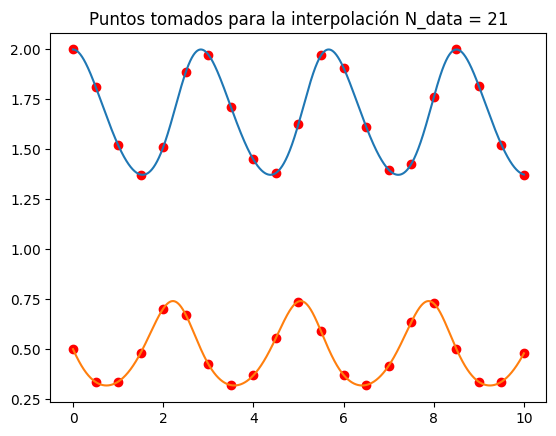

In [ ]:
plt.figure()
plt.plot(t,y)
plt.scatter(t_data,y_data[:,0], c="red")
plt.scatter(t_data,y_data[:,1], c="red")
plt.title(f'Puntos tomados para la interpolación N_data = {len(y_data)}')
plt.show()

### 2.2 Entrenamiento de la red

In [ ]:
# Función de entrenamiento
def train(model, optimizer,loss_fn, t_data, y_data, num_epochs):

  loss_history = []    # Lista para almacenar la pérdida en cada época
  learning_rates = []  # Lista para almacenar los learning rates en cada iteración/época

  for epoch in range(num_epochs):            # Bucle de entrenamiento
    # Calcular las predicciones de la red y las derivadas
    model.train()

    yh = model(t_data)


    # Calcular la pérdida
    loss = loss_fn(yh, y_data)

    # Optimización
    optimizer.zero_grad()  # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()        # Se realiza la retropropagación backward
    optimizer.step()       # Se actualizan los parámetros del modelo mediante el optimizador (optimizer)

    loss_history.append(loss.item())    # almacentar el error


    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)             # almacentar el learning rate
    # Imprimir el progreso
    if (epoch + 1) % print_freq == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {loss.item()}')

  return loss_history, learning_rates, yh   # Devolver la lista de pérdida al final del entrenamiento y el lerning rate

In [ ]:
# Crear una instancia del modelo y del optimizador
# model = PINN(input_size, hidden_size, output_size)
input_size = 1
#hidden_size = 5 , mejor
#hidden_size = 32
#hidden_size = 20
hidden_size = 15
#hidden_size = 10
output_size = 2
# learnig_rate = 0.001
learnig_rate = 0.01
model = PINN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)
loss_fn = nn.MSELoss()


# Registrar el tiempo de inicio
start_time = time.time()

#num_epoch = 10000
#num_epoch = 48000
#num_epoch = 38000
#num_epoch = 30000
num_epoch = 28000
# Entrenar el modelo utilizando la función de entrenamiento
loss_history, learning_rates, yh  = train(model, optimizer, loss_fn,t_data, y_data, num_epoch)

# Registrar el tiempo de finalización
end_time = time.time()

# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

Epoch [2000/28000], Total Loss: 0.014230535365641117
Epoch [4000/28000], Total Loss: 0.00010461950296303257
Epoch [6000/28000], Total Loss: 3.0314471587189473e-05
Epoch [8000/28000], Total Loss: 3.498602382023819e-05
Epoch [10000/28000], Total Loss: 2.2056203306419775e-05
Epoch [12000/28000], Total Loss: 1.793034971342422e-05
Epoch [14000/28000], Total Loss: 2.0742891138070263e-05
Epoch [16000/28000], Total Loss: 4.044134766445495e-05
Epoch [18000/28000], Total Loss: 1.9624598280643113e-05
Epoch [20000/28000], Total Loss: 8.146364416461438e-05
Epoch [22000/28000], Total Loss: 1.0123915672011208e-05
Epoch [24000/28000], Total Loss: 1.2401786989357788e-05
Epoch [26000/28000], Total Loss: 9.869557288766373e-06
Epoch [28000/28000], Total Loss: 5.096632776258048e-06
 
Tiempo de ejecución: 35.1210560798645 segundos


In [ ]:
yh = model(t).detach()
yh
yh.shape

torch.Size([3001, 2])

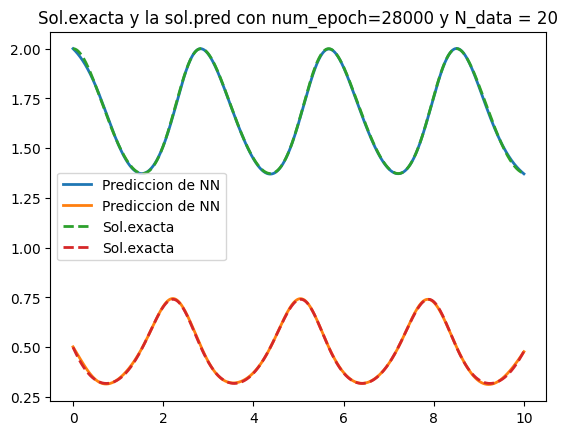

In [ ]:
plt.figure()
plt.plot(t,yh, linewidth=2,label ="Prediccion de NN")
plt.plot(t,sol, linewidth=2, linestyle='--', label='Sol.exacta')
plt.legend()
plt.title(f'Sol.exacta y la sol.pred con num_epoch={num_epoch} y N_data = {k}')
plt.show()


Hemos necesitado


-*Hidden_size* = 32

-*Num_epoch* = 48000

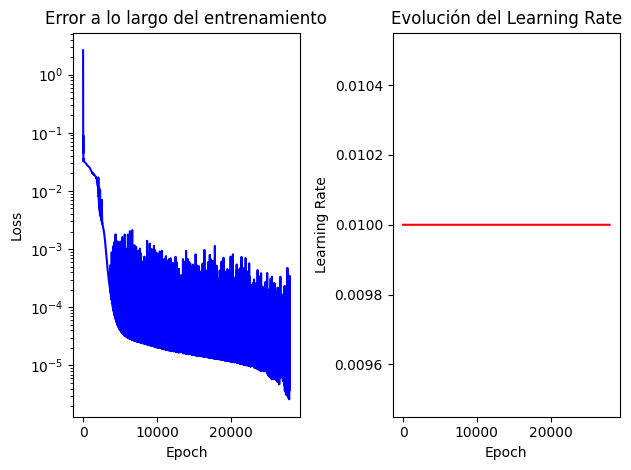

In [ ]:
# Crear una figura con dos subgráficas
plt.figure()
plt.subplot(1,2,1)
# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Error a lo largo del entrenamiento')
plt.yscale('log')

plt.subplot(1,2,2)
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')


# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()

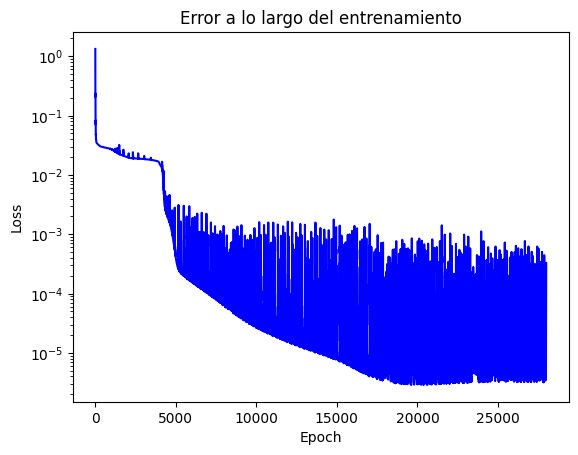

In [ ]:
plt.figure()
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Error a lo largo del entrenamiento')
plt.yscale('log')
plt.show()